# Setup

In [1]:
import os
import random
from copy import deepcopy
from dataclasses import dataclass
from tqdm import tqdm

import torch
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import numpy as np
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )    
import wandb
import matplotlib.pyplot as plt

from data.datasets.web_dataset import get_dataset
from instructflow.utils import show_images, seed_everything   

In [2]:
import yaml
from omegaconf import OmegaConf
import tempfile


with open("configs/sd2_rf_distillation.yaml", "r") as fp:
    config = OmegaConf.load(fp.name)

In [3]:
seed_everything(config.system.random_state)
torch.set_float32_matmul_precision(config.system.pf32_precision)

# Generating Images from Text

In [4]:
# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(config.model.model_id).to(config.trainer.device)

/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

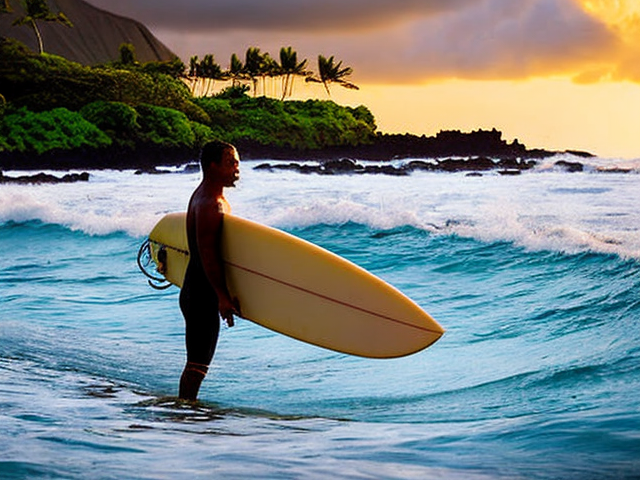

In [5]:
# Set up a generator for reproducibility
generator = torch.Generator(device=config.trainer.device).manual_seed(config.system.random_state)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Surfer on maui", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, 
    width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

# WandB

In [7]:
model_name = "SD 2.1 Reflow 2 Kandinsky4.0 dataset fp32"

wandb.init(
    entity="leffff",
    project="InstructFlow",
    name=model_name,
    resume=True,
    # track hyperparameters and run metadata
    config={
        "architecture": "SD 2.1 U-Net",
        "base_model": config.model.model_id,
        "num_epochs": config.trainer.num_epochs,
        "learning_rate": config.trainer.learning_rate,
        "image_size": config.data.dataset.image_size,
        "batch_size": config.data.dataloader.batch_size
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: leffff. Use `wandb login --relogin` to force relogin


# Dataset

In [8]:
import math

approx_num_samples, dataset = get_dataset(config.data)
approx_num_batches = math.ceil(approx_num_samples / config.data.dataloader.batch_size)

dataloader = DataLoader(
        dataset,
        batch_size=config.data.dataloader.batch_size,
        num_workers=config.data.dataloader.num_workers,
        pin_memory=True,
    )

!!! DATASET SIZE !!! 278964


In [9]:
null_prompts = [''] * config.data.dataloader.batch_size
null_encoder_out = pipe.tokenizer(null_prompts, padding="max_length", max_length=pipe.tokenizer.model_max_length, return_tensors="pt")

with torch.no_grad():
    null_encoder_hidden_states = pipe.text_encoder(
        null_encoder_out["input_ids"].to(config.trainer.device), 
        null_encoder_out["attention_mask"].to(config.trainer.device)
    )['last_hidden_state']

null_encoder_hidden_states.shape

torch.Size([128, 77, 1024])

# Train loop

In [10]:
import torch
from torch.nn import functional as F
from torch.distributions.normal import Normal


def flow_matching_loss(student_model, x_0, x_1, t, encoder_hidden_states):
    t = t.reshape((t.shape[0], 1, 1, 1))
    x_t = t * x_1 + (1 - t) * x_0
    t = t.flatten()
    
    student_pred = student_model(x_t, t, encoder_hidden_states=encoder_hidden_states).sample
    
    return F.mse_loss(student_pred, (x_1 - x_0), reduction="mean")

In [11]:
def generate(unet, vae, x_0, encoder_hidden_states, n_steps: int = 100, device: str = "cuda"):
    unet.to(device)
    vae.to(device)
    unet.eval()
    vae.eval()
    
    x_t = x_0.to(device)

    bs = x_0.shape[0]
    
    eps = 1e-8
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(device)

    for i in range(1, len(t)):
        t_prev = t[i - 1].unsqueeze(0).repeat((bs,))

        with torch.no_grad():
            f_eval = unet(x_t, t_prev, encoder_hidden_states=encoder_hidden_states).sample
            
        x_t = x_t + (t[i] - t[i - 1]) * f_eval

    with torch.no_grad():
        x_t = vae.decode(x_t / 0.18215).sample
    
    return x_t


def sample_x1(unet, vae, x_0, encoder_hidden_states, n_steps: int = 100, device: str = "cuda"):
    unet.to(device)
    vae.to(device)
    
    unet.eval()
    vae.eval()
    
    x_t = x_0.to(device)

    bs = x_0.shape[0]
    
    eps = 1e-8
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(device)

    for i in range(1, len(t)):
        t_prev = t[i - 1].unsqueeze(0).repeat((bs,))

        with torch.no_grad():
            f_eval = unet(x_t, t_prev, encoder_hidden_states=encoder_hidden_states).sample
            
        x_t = x_t + (t[i] - t[i - 1]) * f_eval
    
    return x_t


def sample_x1_cfg(unet, vae, x_0, encoder_hidden_states, null_encoder_hidden_states, guidance_scale, n_steps: int = 100, device: str = "cuda"):
    unet.to(device)
    unet.eval()    

    x_t = x_0.to(device)

    bs = x_0.shape[0]
    
    eps = 1e-8
    t = torch.linspace(eps, 1 - eps, n_steps + 1).to(device)
    h = 1 / n_steps 
    
    for i in range(1, len(t)):
        t_prev = t[i - 1].unsqueeze(0).repeat((bs,))
        with torch.no_grad():
            x_t_cond, x_t_uncond = unet(
                      torch.cat([x_t, x_t], dim=0),
                      torch.cat([t_prev, t_prev], dim=0), 
                      encoder_hidden_states=torch.cat([encoder_hidden_states, null_encoder_hidden_states], dim=0)
                  ).sample.chunk(2)
            
            k1 = (1 - guidance_scale) * x_t_uncond + guidance_scale * x_t_cond
            
            x_t = x_t + h * k1

    return x_t

In [12]:
def train_epoch(student_unet, teacher_unet, vae, text_encoder, dataloader, loss_function, optimizer, scheduler, device):
    student_unet.to(device)
    teacher_unet.to(device)
    vae.to(device)
    text_encoder.to(device)
    
    student_unet.train()
    teacher_unet.eval()
    vae.eval()
    text_encoder.eval()

    total_loss = 0
    batch_i = 0
    for batch in tqdm(dataloader):
        x_1, input_ids, attention_mask = batch
        x_1, input_ids, attention_mask = x_1.to(device), input_ids.to(device), attention_mask.to(device)
        bs = x_1.shape[0]

        with torch.no_grad():
            x_1_latents = 0.18215 * vae.encode(x_1).latent_dist.mean
            encoder_hidden_states = text_encoder(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']

        x_0_latent = torch.randn_like(x_1_latents, device=device)
        t = torch.sigmoid(torch.randn((bs,), device=device))

        x_1_latents_sampled = sample_x1_cfg(
            unet=teacher_unet, 
            vae=vae, 
            x_0=x_0_latent, 
            encoder_hidden_states=encoder_hidden_states, 
            null_encoder_hidden_states=null_encoder_hidden_states,
            guidance_scale=9,
            device=device,
            n_steps=50
        )

        loss = loss_function(student_unet, x_0_latent, x_1_latents_sampled, t, encoder_hidden_states)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(student_unet.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        total_loss += loss.item() 
        batch_i += 1

        if batch_i % 1000 == 0:
            x_gen = generate(unet=student_unet, vae=vae, x_0=x_0_latent[:16], encoder_hidden_states=encoder_hidden_states[:16], device=device)
           
            log = {
                "loss": total_loss / 1000,
                "generated_images": wandb.Image(show_images(x_gen)),
            }
            wandb.log(log)
            
            total_loss = 0

            torch.save(student_unet.state_dict(), f"/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_rf_2_generation_v1/{batch_i}.pt")

# Model

In [13]:
teacher_unet = pipe.unet.train()
student_unet = deepcopy(pipe.unet).train()

vae = pipe.vae.eval()
text_encoder = pipe.text_encoder.eval()

last_checkpoint = os.listdir("/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_fm_generation_v1")[-1]
teacher_unet.load_state_dict(torch.load(f"/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_fm_generation_v1/{last_checkpoint}"))
student_unet.load_state_dict(torch.load(f"/home/jovyan/shares/SR004.nfs2/novitskiy/instructflow/checkpoints/sd_2_1_fm_generation_v1/{last_checkpoint}"))

optimizer = torch.optim.Adam(student_unet.parameters(), lr=config.trainer.learning_rate)

scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.trainer.lr_warmup_steps,
    num_training_steps=approx_num_batches * config.trainer.num_epochs
)

# Let's Train

In [ ]:
for i in range(config.trainer.num_epochs):
    train_epoch(
        student_unet=student_unet, 
        teacher_unet=teacher_unet, 
        vae=vae, 
        text_encoder=text_encoder,
        dataloader=dataloader,
        loss_function=flow_matching_loss,
        optimizer=optimizer, 
        scheduler=scheduler, 
        device=config.trainer.device
    )

0it [00:00, ?it/s]/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (167076000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/jovyan/.mlspace/envs/video-movq/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (104040000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
3it [02:03, 39.96s/it]